In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Load the MNIST dataset:

In [42]:
# Load MNIST dataset
(train_set_im, train_lab), (test_set_im, test_lab) = datasets.mnist.load_data()

# Normalize images (scale values from 0-255 to 0-1)
train_set_im = (train_set_im / 255.0).astype(np.float32)
test_set_im = test_set_im / 255.0

# Flatten images into vectors
train_set = train_set_im.reshape(-1, 28*28)
test_set = test_set_im.reshape(-1, 28*28)

# Convert to datasets for batching
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_set,train_lab))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Simple two-hidden layer neural network:
$$
\mathrm{ReLU}\Big(\mathrm{ReLU}(x W_1 + b_1) W_2 + b_2\Big) W_3 + b_3
$$

Where $W_1$, $W_2$, and $W_3$ are weighted matrices and x is an input batch.
---




Setup a sequential neural network to train on the dataset.

In [7]:
# Hidden layer size
h = 128
input_size = 784
output_size = 10

# Weight matrices
W1 = tf.Variable(tf.random.normal(shape=(input_size, h)), name = 'W1')
W2 = tf.Variable(tf.random.normal(shape=(h, h)), name = 'W2')
W3 = tf.Variable(tf.random.normal(shape=(h, output_size)), name = 'W3')
# Biases
b1 = tf.Variable(tf.zeros(shape=(h,)), name = 'b1')
b2 = tf.Variable(tf.zeros(shape=(h,)), name = 'b2')
b3 = tf.Variable(tf.zeros(shape=(output_size,)), name = 'b3')

# Run the model for a batch of input
def run(in_batch):
  # Hidden layers h1 and h2
  h1 = tf.nn.relu((in_batch @ W1) + b1)
  h2 = tf.nn.relu((h1 @ W2) + b2)
  output = (h2 @ W3) + b3
  return output

# Compute Loss for a batch of input
def get_loss(in_batch, true_labels):
  return tf.keras.losses.sparse_categorical_crossentropy(true_labels,
                                                         run(in_batch),
                                                         from_logits = True)

# Train the model
def train(dataset, epochs=5, target_acc=0.975, acc_plot=False):
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  train_losses = []
  test_accuracies = []

  for epoch in range(epochs):
    # Exit early if we reach the desired accuracy
    if evaluate(test_set, test_lab) > target_acc:
      break
    for x_batch, y_batch in dataset:
      # Get the gradients of all parameters and update them using an optimizer
      with tf.GradientTape() as tape:
        loss = tf.reduce_mean(get_loss(x_batch, y_batch))
      gradients = tape.gradient(loss, [W1,b1,W2,b2,W3,b3])
      optimizer.apply_gradients(zip(gradients, [W1,b1,W2,b2,W3,b3]))

      if acc_plot:
        acc = evaluate(test_set, test_lab)
        if acc > target_acc:
          break
        train_losses.append(loss.numpy())
        test_accuracies.append(acc)

  if acc_plot:
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Loss", color="red")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(test_accuracies, label="Accuracy", color="blue")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy")
    plt.ylim(0, 1)   # force scale between 0 and 1
    plt.legend()
    plt.show()

  # Save checkpoint after training finishes
  ckpt = tf.train.Checkpoint(W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
  ckpt.save("mnist_model.ckpt")

# Evaluate the model
def evaluate(test_set, test_lab):
  logits = run(test_set)
  predictions = tf.argmax(logits, axis=1)
  accuracy = tf.reduce_mean(tf.cast(predictions == test_lab, tf.float32))
  return accuracy.numpy()

Train the model, and plot loss and accuracy over each batch:

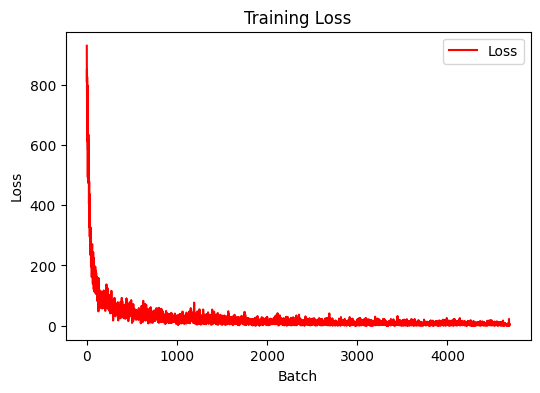

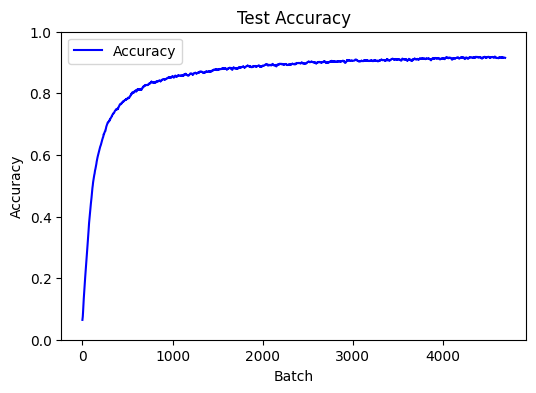

In [8]:
train(train_dataset, acc_plot=True)

# Convolutional Neural Network:
$$
Input→C→N→R→P→C→N→R→P→F→Dr→De→De→Output
$$
Key:

C = Convolutional Layer,
N = Normalization Layer,
P = Pooling Layer,
R = ReLU Operation,
Dr = Dropout Layer,
De = Dense Layer

In [43]:
# Setup the model:
input = layers.Input(shape=(28,28,1))
x = layers.Conv2D(32, (3,3), activation = 'relu', padding="same")(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation = 'softmax')(x)

model = models.Model(inputs=input, outputs=output)

# Setup the compiler:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Setup an early callback to stop when the model reaches 98% accuracy
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=0,
    baseline=0.99,
    restore_best_weights=True
)
# Train the model:
history = model.fit(train_set_im, train_lab, epochs=5, batch_size=batch_size,
                    validation_data=(test_set_im, test_lab),
                    callbacks=[early_stop])

# Save it:
model.save("mnist_cnn_blipovet.h5")

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 100s 104ms/step - accuracy: 0.8676 - loss: 0.4380 - val_accuracy: 0.9816 - val_loss: 0.0565
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 137s 98ms/step - accuracy: 0.9681 - loss: 0.1083 - val_accuracy: 0.9883 - val_loss: 0.0343
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.9801 - loss: 0.0679 - val_accuracy: 0.9811 - val_loss: 0.0584
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - accuracy: 0.9814 - loss: 0.0627 - val_accuracy: 0.9892 - val_loss: 0.0405
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 95ms/step - accuracy: 0.9846 - loss: 0.0520 - val_accuracy: 0.9900 - val_loss: 0.0374


In [46]:
from tensorflow.keras.models import load_model
model = load_model("mnist_cnn_blipovet.h5")

Plots to analyze the model:

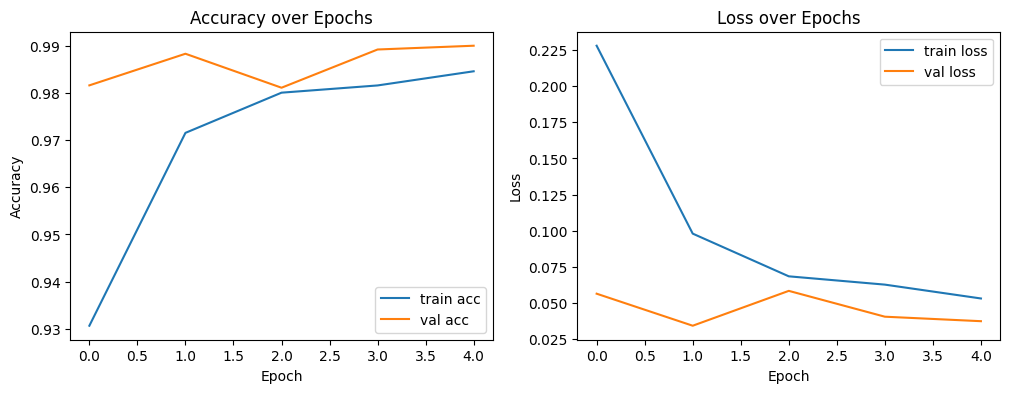

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


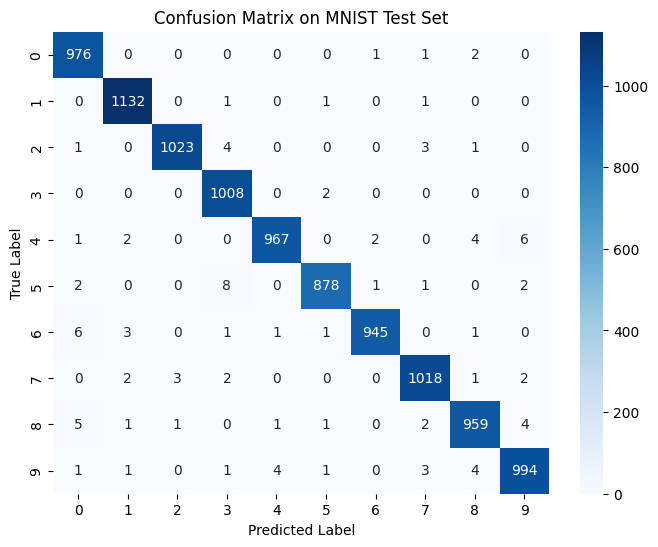

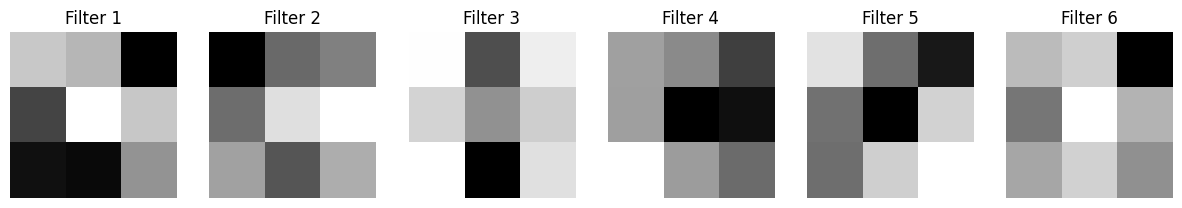

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,532 (1.20 MB)

 Trainable params: 315,338 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

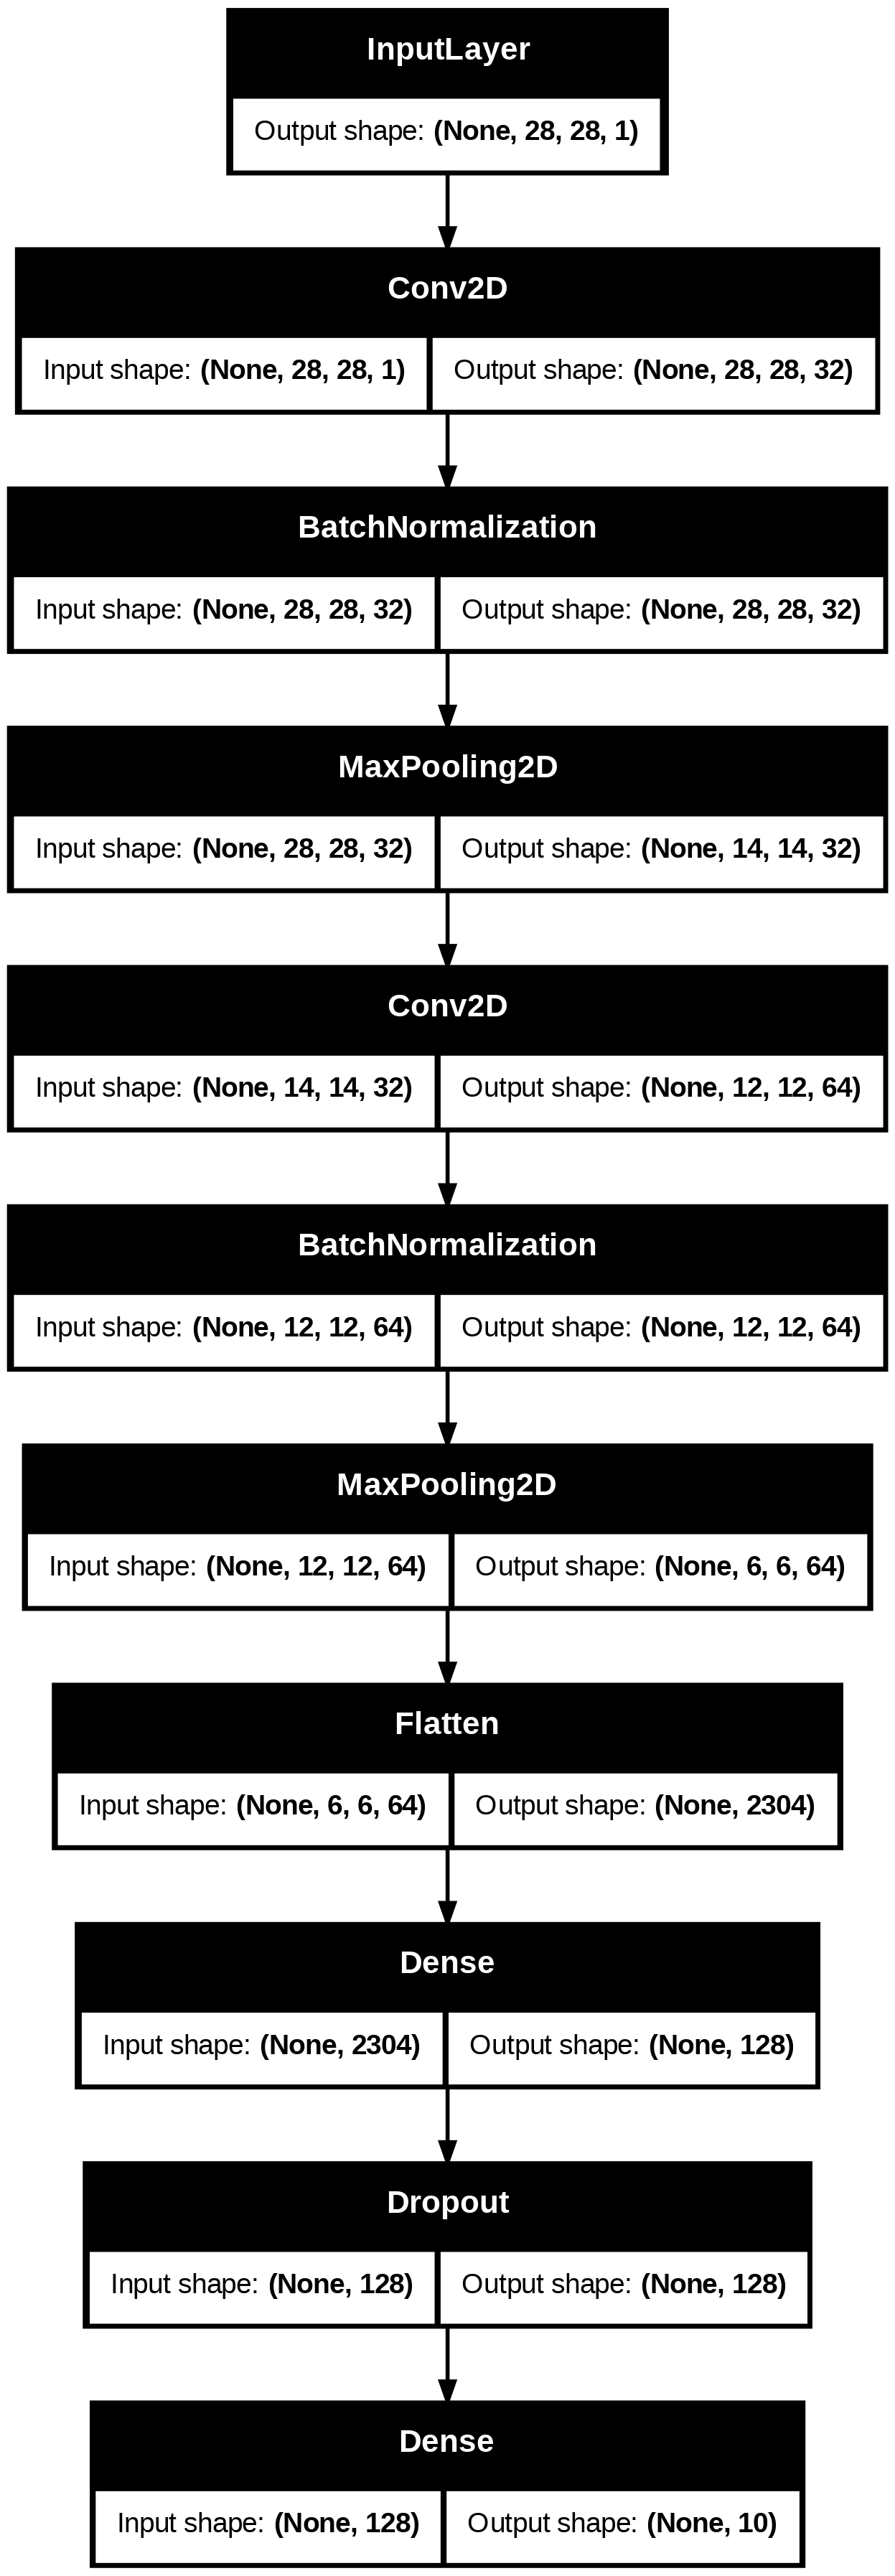

In [51]:

# Plot the model's accuracy and loss over each epoch:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Plot a confusion matrix:

y_pred = model.predict(test_set_im).argmax(axis=1)
cm = confusion_matrix(test_lab, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on MNIST Test Set")
plt.show()

# Plot of the First Convolution Layer's Filters:
# Get the weights of the first Conv2D layer
filters, biases = model.layers[1].get_weights()

# Normalize filter values to 0–1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 6  # show first 6 filters
plt.figure(figsize=(15,5))

for i in range(n_filters):
    ax = plt.subplot(1, n_filters, i+1)
    plt.imshow(filters[:, :, 0, i], cmap="gray")
    plt.axis("off")
    plt.title(f"Filter {i+1}")

plt.show()

# Plot a summary of the model and its structure:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)